# Análise Quantitativa do Trade-off entre Especialização e Generalização em LLMs via Fine-Tuning

**Disciplina:** TÓPICOS ESPECIAIS EM BANCO DE DADOS - NLP  
**Trabalho Prático:** Análise Quantitativa do Trade-off entre Especialização e Generalização em LLMs via Fine-Tuning

- Allan Carvalho de Aguiar (22153696)
- Beatriz Emily Silva Aguiar (22154303)
- Juíle Yoshie Sarkis Hanada (22251135)

**Professor:** Altigran Soares e André Carvalho  
**Data de Entrega:** 23/06/2025    

---


In [1]:
!pip install -U datasets
!pip install transformers
!pip install torch
!pip install accelerate
!pip install bitsandbytes
!pip install huggingface-hub
!pip install -U peft
!pip install -U trl
!pip install -U deepeval
!pip install -U pytest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import os

if not os.path.exists("spider_data"):
  !gdown "1403EGqzIDoHMdQF4c9Bkyl7dZLZ5Wt6J"
  !unzip -q spider_data.zip
  !rm spider_data.zip
else:
  pass

Downloading...
From (original): https://drive.google.com/uc?id=1403EGqzIDoHMdQF4c9Bkyl7dZLZ5Wt6J
From (redirected): https://drive.google.com/uc?id=1403EGqzIDoHMdQF4c9Bkyl7dZLZ5Wt6J&confirm=t&uuid=1b4a9afc-7506-414d-9517-62d03a26a49d
To: /content/spider_data.zip
100% 206M/206M [00:02<00:00, 77.1MB/s]


In [3]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get('HF_TOKEN')

login(token=hf_token)

In [4]:
from datasets import load_dataset
spider_dataset = load_dataset("spider")
spider_dataset

README.md:   0%|          | 0.00/5.51k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/831k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/126k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1034 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 1034
    })
})

### Dataset de Fine-Tuning e Dataset de Avaliação de Tarefa

In [5]:
train_spider = spider_dataset['train']
validation_spider = spider_dataset['validation']

del spider_dataset

### Dataset de Avaliação de Generalização

In [6]:
mmlu_dataset = load_dataset("cais/mmlu", "all")
mmlu_dataset

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

auxiliary_train-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
})

### Criação da Suíte de Avaliação Composta

In [7]:
from datasets import concatenate_datasets, DatasetDict
import pandas as pd

# 1. Definir as subcategorias escolhidas e o número de questões
NUM_QUESTIONS_PER_CATEGORY = 50
CATEGORIES = {
    "stem": "college_computer_science", # Changed 'computer_science' to a valid subject name
    "humanities": "philosophy",
    "social_sciences": "econometrics" # Changed from 'professional_economics' to 'econometrics'
}

# Lista para armazenar os datasets de cada categoria
selected_datasets = []

print("Iniciando o processo de criação da suíte de avaliação MMLU...")
print("-" * 50)

# 2. Loop para carregar, embaralhar e selecionar dados de cada categoria
for category, mmlu_subject in CATEGORIES.items():
    print(f"Processando categoria: {category.upper()} (Subcategoria MMLU: {mmlu_subject})")

    # Carrega a subcategoria específica do MMLU
    current_subject_dataset_dict = load_dataset("cais/mmlu", mmlu_subject)

    # Usamos o split 'test' que é padrão para avaliação
    dataset = current_subject_dataset_dict['test']

    # Embaralha o dataset para garantir uma seleção aleatória e reprodutível (com seed)
    # e seleciona o número desejado de questões
    shuffled_dataset = dataset.shuffle(seed=42).select(range(NUM_QUESTIONS_PER_CATEGORY))

    selected_datasets.append(shuffled_dataset)
    print(f"-> {len(shuffled_dataset)} questões selecionadas para '{mmlu_subject}'.")

print("-" * 50)

# 3. Combinar os três datasets em um único dataset final
final_evaluation_dataset = concatenate_datasets(selected_datasets)

del selected_datasets

# Embaralhar o dataset final para misturar as categorias
final_evaluation_dataset = final_evaluation_dataset.shuffle(seed=42)

# 4. Criar o DatasetDict final, como solicitado
evaluation_suite = DatasetDict({
    "evaluation": final_evaluation_dataset
})

print("Suíte de avaliação criada com sucesso!")
print("\nEstrutura final do DatasetDict:")
print(evaluation_suite)

# 5. Verificação opcional: contar as questões por disciplina para garantir a divisão correta
print("\nVerificando a distribuição das questões por disciplina:")
df = evaluation_suite["evaluation"].to_pandas()
subject_counts = df['subject'].value_counts()
print(subject_counts)

Iniciando o processo de criação da suíte de avaliação MMLU...
--------------------------------------------------
Processando categoria: STEM (Subcategoria MMLU: college_computer_science)


test-00000-of-00001.parquet:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.25k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

-> 50 questões selecionadas para 'college_computer_science'.
Processando categoria: HUMANITIES (Subcategoria MMLU: philosophy)


test-00000-of-00001.parquet:   0%|          | 0.00/48.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.15k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.20k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/311 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

-> 50 questões selecionadas para 'philosophy'.
Processando categoria: SOCIAL_SCIENCES (Subcategoria MMLU: econometrics)


test-00000-of-00001.parquet:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/114 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

-> 50 questões selecionadas para 'econometrics'.
--------------------------------------------------
Suíte de avaliação criada com sucesso!

Estrutura final do DatasetDict:
DatasetDict({
    evaluation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 150
    })
})

Verificando a distribuição das questões por disciplina:
subject
philosophy                  50
econometrics                50
college_computer_science    50
Name: count, dtype: int64


In [8]:
def criar_prompt_llama3(schema, question):
    """
    Cria um prompt de few-shot no formato específico e recomendado
    para a família Llama 3 Instruct.
    """
    # Instrução principal movida para o 'role' de sistema.
    system_prompt = "Você é um especialista em SQL. Sua tarefa é gerar uma consulta SQL precisa a partir de uma pergunta em linguagem natural e o esquema do banco de dados fornecido. Não adicione nenhuma explicação, apenas o código SQL."

    # A estrutura f-string principal que formata a conversa.
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 1 (Fácil)
### Esquema do Banco de Dados:
# CREATE TABLE cars_data (cylinders INTEGER)
### Pergunta:
# What is the number of cars with more than 4 cylinders?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT COUNT(*) FROM cars_data WHERE cylinders > 4<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 2 (Médio)
### Esquema do Banco de Dados:
# CREATE TABLE concert (stadium_id INTEGER)
# CREATE TABLE stadium (stadium_id INTEGER, name TEXT)
### Pergunta:
# For each stadium, how many concerts are there?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT T2.name, COUNT(*) FROM concert AS T1 JOIN stadium AS T2 ON T1.stadium_id = T2.stadium_id GROUP BY T2.name<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 3 (Difícil)
### Esquema do Banco de Dados:
# CREATE TABLE continents (cont_id INTEGER, continent TEXT)
# CREATE TABLE countries (country_id INTEGER, country_name TEXT, continent INTEGER)
# CREATE TABLE car_makers (maker_id INTEGER, maker TEXT, country INTEGER)
### Pergunta:
# Which countries in Europe have at least 3 car manufacturers?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT T1.country_name FROM countries AS T1 JOIN continents AS T2 ON T1.continent = T2.cont_id JOIN car_makers AS T3 ON T1.country_id = T3.country WHERE T2.continent = 'Europe' GROUP BY T1.country_name HAVING COUNT(*) >= 3<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 4 (Extra Difícil)
### Esquema do Banco de Dados:
# CREATE TABLE country (Code TEXT, Name TEXT, LifeExpectancy REAL)
# CREATE TABLE country_language (CountryCode TEXT, Language TEXT, IsOfficial TEXT)
### Pergunta:
# What is the average life expectancy in the countries where English is not the official language?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT AVG(LifeExpectancy) FROM country WHERE Name NOT IN (SELECT T1.Name FROM country AS T1 JOIN country_language AS T2 ON T1.Code = T2.CountryCode WHERE T2.Language = "English" AND T2.IsOfficial = "T")<|eot_id|><|start_header_id|>user<|end_header_id|>
### Agora é a sua vez.

### Esquema do Banco de Dados:
# {schema}
### Pergunta:
# {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
    return prompt

def criar_prompt_mistral(schema, question):
    """
    Cria um prompt de few-shot no formato específico para o Mistral-7B-Instruct-v0.2.
    """
    # O prompt para o Mistral usa as tags [INST] e [/INST] para delimitar as instruções do usuário.
    # A resposta do assistente vem logo após a tag de fechamento [/INST].
    prompt = f"""<s>[INST]Você é um especialista em SQL. Sua tarefa é gerar uma consulta SQL precisa a partir de uma pergunta em linguagem natural e o esquema do banco de dados fornecido. Não adicione nenhuma explicação, apenas o código SQL.

### Exemplo 1
### Esquema do Banco de Dados:
# CREATE TABLE head (age INTEGER, name TEXT)
# CREATE TABLE department (name TEXT, num_employees INTEGER)
### Pergunta:
# List all department names that have more than 20 employees.[/INST]
SELECT name FROM department WHERE num_employees > 20</s>
[INST]### Exemplo 2
### Esquema do Banco de Dados:
# CREATE TABLE singer (Name TEXT, Country TEXT, Age INTEGER)
# CREATE TABLE song (Title TEXT, Singer TEXT)
### Pergunta:
# What are the names of singers from France?[/INST]
SELECT Name FROM singer WHERE Country = 'France'</s>
[INST]### Exemplo 3
### Esquema do Banco de Dados:
# CREATE TABLE concert (Theme TEXT, Year INTEGER)
# CREATE TABLE singer_in_concert (concert_Theme TEXT, singer_Name TEXT)
### Pergunta:
# Count the number of singers in concerts for each theme.[/INST]
SELECT T1.Theme, count(*) FROM concert AS T1 JOIN singer_in_concert AS T2 ON T1.Theme  =  T2.concert_Theme GROUP BY T1.Theme</s>
[INST]### Fim dos Exemplos. Agora, sua vez.

### Esquema do Banco de Dados:
# {schema}
### Pergunta:
# {question}[/INST]
"""
    return prompt

In [9]:
schema_teste = "CREATE TABLE students (name TEXT, grade REAL)"
pergunta_teste = "What are the names of students with a grade above 8.5?"

prompt_final = criar_prompt_llama3(schema_teste, pergunta_teste)
print(prompt_final)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>
Você é um especialista em SQL. Sua tarefa é gerar uma consulta SQL precisa a partir de uma pergunta em linguagem natural e o esquema do banco de dados fornecido. Não adicione nenhuma explicação, apenas o código SQL.<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 1 (Fácil)
### Esquema do Banco de Dados:
# CREATE TABLE cars_data (cylinders INTEGER)
### Pergunta:
# What is the number of cars with more than 4 cylinders?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT COUNT(*) FROM cars_data WHERE cylinders > 4<|eot_id|><|start_header_id|>user<|end_header_id|>
### Exemplo 2 (Médio)
### Esquema do Banco de Dados:
# CREATE TABLE concert (stadium_id INTEGER)
# CREATE TABLE stadium (stadium_id INTEGER, name TEXT)
### Pergunta:
# For each stadium, how many concerts are there?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
SELECT T2.name, COUNT(*) FROM concert AS T1 JOIN stadium AS T2 ON T1.stadium_

## Carregar o modelo llama 3

In [11]:
import requests
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm
import time

# --- Configuração ---
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

COMMIT_HASH = "0cb88a4f764b7a12671c53f0838cd831a0843b95"

print("Carregando o tokenizador...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, COMMIT_HASH, token=hf_token)

# Configuração de quantização para carregar o modelo em 4-bit
bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,
    load_in_4bit=True,
    # bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16,
    # bnb_4bit_use_double_quant=True,
)

# Carregar o modelo base com quantização
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    revision=COMMIT_HASH,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM

# # Modelo leve e público, ideal para testar pipeline
# MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# print("Carregando o tokenizador...")
# tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

# print("Carregando o modelo...")
# model = AutoModelForCausalLM.from_pretrained(
#     MODEL_ID,
#     device_map="auto" if torch.cuda.is_available() else None,
# )



Carregando o tokenizador...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [12]:
def formatar_schema(exemplo_spider):
    """
    Formata o esquema de um banco de dados em formato CREATE TABLE,
    utilizando um dicionário de esquemas pré-carregado (schemas_map).

    Args:
        exemplo_spider (dict): Um único exemplo do dataset Spider.

    Returns:
        str: Uma string com as declarações CREATE TABLE para o banco de dados.
    """
    db_id = exemplo_spider['db_id']

    if db_id not in schemas_map:
        return f"ERRO: Esquema para o db_id '{db_id}' não encontrado."

    schema_info = schemas_map[db_id]

    # Extrair as listas relevantes do esquema
    table_names = schema_info['table_names_original']
    column_names = schema_info['column_names_original']
    column_types = schema_info['column_types']

    schema_parts = []
    # Iterar sobre cada tabela para construir sua declaração
    for table_idx, table_name in enumerate(table_names):
        cols_da_tabela = []

        # Iterar sobre o ÍNDICE das colunas para acessar as listas paralelas
        for i in range(len(column_names)):
            # Verificar se a coluna atual (índice i) pertence à tabela atual (table_idx)
            if column_names[i][0] == table_idx:
                col_name = column_names[i][1]
                col_type = column_types[i]
                cols_da_tabela.append(f"{col_name} {col_type}")

        schema_parts.append(f"CREATE TABLE {table_name} ({', '.join(cols_da_tabela)})")

    return "\n".join(schema_parts)

In [13]:
# --- Execução da Avaliação ---
resultados = []
DB_DIR = "spider_data/database"
# `torch.no_grad()` desativa o cálculo de gradientes, economizando memória e acelerando a inferência.
with torch.no_grad():
    for i, exemplo in enumerate(tqdm(validation_spider.select(range(50)), desc="Avaliando Llama 3")):
        pergunta = exemplo['question']
        query_correta = exemplo['query']
        db_id = exemplo['db_id']

        schema_formatado = formatar_schema(exemplo)
        prompt_completo = criar_prompt_llama3(schema_formatado, pergunta)
        path_db = os.path.join(DB_DIR, db_id, f"{db_id}.sqlite")

        # 1. Tokenizar o prompt
        # O prompt é convertido em números que o modelo entende.
        inputs = tokenizer(prompt_completo, return_tensors="pt").to(model.device)

        # 2. Gerar a resposta com o modelo
        # O modelo gera a continuação do prompt tokenizado.
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False # Usamos do_sample=False para obter resultados mais consistentes
        )

        # 3. Decodificar a resposta
        # Os números gerados são convertidos de volta para texto.
        # `outputs[0]` pega o primeiro (e único) resultado do lote.
        # `inputs.input_ids.shape[1]:` fatia a saída para remover o prompt original e manter apenas o texto gerado.
        query_gerada = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        resultados.append({
            "db_id": exemplo['db_id'],
            "pergunta": pergunta,
            "query_correta": query_correta,
            "query_gerada": query_gerada,
            "db_path": path_db,
        })

        # Opcional: Limpar o cache da GPU em loops longos
        # torch.cuda.empty_cache()

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("llama3_local_baseline_resultados.csv", index=False)

print("\nAvaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_local_baseline_resultados.csv'")
# print(df_resultados.head())

Avaliando Llama 3:   0%|          | 0/50 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   2%|▏         | 1/50 [00:01<00:56,  1.16s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   4%|▍         | 2/50 [00:01<00:33,  1.42it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   6%|▌         | 3/50 [00:02<00:46,  1.02it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRAN


Avaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_local_baseline_resultados.csv'


In [14]:
import sqlite3

# O nome do arquivo gerado pelo script de execução local
ARQUIVO_DE_RESULTADOS = "llama3_local_baseline_resultados.csv"

def verificar_execucao(query_gerada, query_correta, db_path):
    """
    Verifica se a query gerada produz o mesmo resultado que a query correta.
    Retorna True para sucesso, False para falha.
    """
    # Se o modelo não gerou nada ou retornou um erro, é uma falha.
    if not isinstance(query_gerada, str) or not query_gerada.strip():
        return False

    conexao = None
    try:
        # Conectar ao banco de dados específico deste exemplo
        conexao = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True) # Modo somente leitura
        cursor = conexao.cursor()

        # Executar la query correta (padrão ouro)
        cursor.execute(query_correta)
        resultado_correto = cursor.fetchall()

        # Tentar executar la query gerada pelo modelo
        cursor.execute(query_gerada)
        resultado_gerado = cursor.fetchall()

        # Converter todos os elementos dos resultados para string antes de ordenar para evitar TypeError
        # Isso garante que todos os elementos sejam comparáveis.
        resultado_gerado_str = [tuple(str(item) for item in row) for row in resultado_gerado]
        resultado_correto_str = [tuple(str(item) for item in row) for row in resultado_correto]

        # print(resultado_gerado_str)
        # print(resultado_correto_str)

        # A ordem dos resultados de uma consulta SQL não é garantida sem ORDER BY.
        # Portanto, a comparação mais robusta é ordenar os resultados antes de comparar.
        return sorted(resultado_gerado_str) == sorted(resultado_correto_str)

    except sqlite3.Error:
        # Qualquer erro de sintaxe ou execução na query gerada é uma falha.
        return False
    finally:
        # Garantir que a conexão seja sempre fechada.
        if conexao:
            conexao.close()

In [15]:
try:
    df_resultados = pd.read_csv(ARQUIVO_DE_RESULTADOS)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{ARQUIVO_DE_RESULTADOS}' não encontrado.")
    print("Certifique-se de que o script de avaliação local foi executado e gerou o arquivo CSV.")
    exit()

sucessos = 0
total = len(df_resultados)
resultados_detalhados = []

print(f"Iniciando a verificação por execução para {total} exemplos...")

for index, row in tqdm(df_resultados.iterrows(), total=total, desc="Verificando Resultados"):
    status = verificar_execucao(row['query_gerada'], row['query_correta'], row['db_path'])

    if status:
        sucessos += 1
        resultados_detalhados.append('Sucesso')
    else:
        resultados_detalhados.append('Falha')

# Adicionar uma coluna com os resultados da verificação para análise posterior
df_resultados['status_execucao'] = resultados_detalhados
df_resultados.to_csv("llama3_local_resultados_verificados.csv", index=False)

# --- Relatório Final de Baseline ---
print("\n--- Relatório de Baseline (Execução Local) ---")
print(f"Total de Amostras Avaliadas: {total}")
print(f"Número de Sucessos (Execution Accuracy): {sucessos}")
print(f"Número de Falhas: {total - sucessos}")

if total > 0:
    taxa_de_sucesso = (sucessos / total) * 100
    print(f"Taxa de Sucesso Bruta: {taxa_de_sucesso:.2f}%")

print("\nResultados detalhados foram salvos em 'llama3_local_resultados_verificados.csv'")

Iniciando a verificação por execução para 50 exemplos...


Verificando Resultados: 100%|██████████| 50/50 [00:00<00:00, 2496.07it/s]


--- Relatório de Baseline (Execução Local) ---
Total de Amostras Avaliadas: 50
Número de Sucessos (Execution Accuracy): 26
Número de Falhas: 24
Taxa de Sucesso Bruta: 52.00%

Resultados detalhados foram salvos em 'llama3_local_resultados_verificados.csv'


### Interpretação:
- **Execution Accuracy**: 52% das queries SQL geradas pelo modelo retornaram exatamente os mesmos resultados que a query correta (do dataset Spider).
- A métrica avalia se a **execução da query é semanticamente correta**, não apenas textual.
- O resultado é razoável para um modelo pequeno (3B) com LoRA, e pode ser melhorado com mais dados ou um modelo maior (ex: 7B ou 8B).

---

# Fase 2: Execução do Fine-Tuning

In [16]:
import gc
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer, SFTConfig

gc.collect()

# -- Configuração do LoRA
# Estes são os parâmetros do nosso "plugin" LoRA
lora_config = LoraConfig(
    r=16,  # Rank: A dimensão das matrizes do adaptador. Valores comuns: 8, 16, 32, 64.
    lora_alpha=32, # Um escalar de normalização. Convenção comum: alpha = 2 * r.
    target_modules=[ # Módulos do modelo onde os adaptadores serão injetados.
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
    ],
    lora_dropout=0.05, # Dropout para as camadas LoRA.
    bias="none",
    task_type="CAUSAL_LM",
)

In [17]:
# -- Configuração do Treinamento
# Aqui definimos os hiperparâmetros do processo de treinamento.
training_arguments_v1 = SFTConfig(
    output_dir="./resultados/llama3-lora-exp1",
    num_train_epochs=1, # Número de vezes que o modelo verá o dataset inteiro
    per_device_train_batch_size=2, # Número de exemplos por lote por GPU
    gradient_accumulation_steps=2, # Acumula gradientes para simular um lote maior
    learning_rate=2e-4, # Taxa de aprendizado (Hiperparâmetro para experimentar)
    optim="paged_adamw_32bit", # Otimizador eficiente em memória
    logging_steps=25, # A cada quantos passos registrar o log de treino
    save_strategy="epoch", # Salvar o checkpoint ao final de cada época
    fp16=True, # Usar precisão de 16 bits para acelerar o treino
    push_to_hub=False, # Não salvar no Hugging Face
    report_to="none",  # <- ESSENCIAL para evitar WandB
)

average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.


In [18]:
# Função para formatar o prompt para o SFTTrainer
# O SFTTrainer espera uma única coluna de texto, formatada como uma conversa.
def formatar_exemplo_para_treino(exemplo):
    # Reutilizando a função de prompt anti-join que criamos
    schema = formatar_schema(exemplo)

    system_prompt = "Você é um especialista em SQL. Sua tarefa é gerar uma consulta SQL precisa a partir de uma pergunta em linguagem natural e o esquema do banco de dados fornecido. Não adicione nenhuma explicação, apenas o código SQL."

    # Formato Llama 3 original
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>
### Esquema do Banco de Dados:
# {schema}
### Pergunta:
# {exemplo['question']}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
{exemplo['query']}<|eot_id|>"""
    return {"text": prompt}


In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# --- 3. CARREGAMENTO DO MODELO E TOKENIZADOR ---

gc.collect()
torch.cuda.empty_cache()

# Configuração de quantização para carregar o modelo em 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    # bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16,
    # bnb_4bit_use_double_quant=True,
)

MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
COMMIT_HASH = "0cb88a4f764b7a12671c53f0838cd831a0843b95"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    revision=COMMIT_HASH,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, COMMIT_HASH, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token # Configurar o token de padding

model.config.use_cache = False # Necessário para o treino com LoRA

formatted_dataset = train_spider.map(formatar_exemplo_para_treino)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [20]:
# --- 4. CONFIGURAÇÃO E EXECUÇÃO DO TREINADOR (SFTTrainer) ---
os.environ["WANDB_DISABLED"] = "true"

# SFTTrainer é uma classe otimizada para Supervised Fine-Tuning
trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset,
    peft_config=lora_config, # Passamos a configuração do LoRA aqui
    processing_class=tokenizer,
    args=training_arguments_v1, # Passamos os argumentos de treino aqui
)

print("Iniciando o fine-tuning com LoRA...")
trainer.train()

print("Fine-tuning concluído!")

# Salvar o adaptador LoRA treinado
# Note que isso salva apenas os pesos do adaptador (~dezenas de MB), não o modelo inteiro.
trainer.save_model(training_arguments_v1.output_dir)
print(f"Adaptador LoRA salvo em: {training_arguments_v1.output_dir}")

Adding EOS to train dataset:   0%|          | 0/7000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/7000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Iniciando o fine-tuning com LoRA...


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss
25,1.225100
50,0.867100
75,0.728600
100,0.657600
125,0.582700
150,0.510600
175,0.517700
200,0.411500
225,0.406600
250,0.391900


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Fine-tuning concluído!
Adaptador LoRA salvo em: ./resultados/llama3-lora-exp1


In [21]:
# --- Execução da Avaliação ---
resultados = []
DB_DIR = "spider_data/database"

model = PeftModel.from_pretrained(model, training_arguments_v1.output_dir)
# `torch.no_grad()` desativa o cálculo de gradientes, economizando memória e acelerando a inferência.
with torch.no_grad():
    for i, exemplo in enumerate(tqdm(validation_spider.select(range(50)), desc="Avaliando Llama 3")):
        pergunta = exemplo['question']
        query_correta = exemplo['query']
        db_id = exemplo['db_id']

        schema_formatado = formatar_schema(exemplo)
        prompt_completo = criar_prompt_llama3(schema_formatado, pergunta)
        path_db = os.path.join(DB_DIR, db_id, f"{db_id}.sqlite")

        # 1. Tokenizar o prompt
        # O prompt é convertido em números que o modelo entende.
        inputs = tokenizer(prompt_completo, return_tensors="pt").to(model.device)

        # 2. Gerar a resposta com o modelo
        # O modelo gera a continuação do prompt tokenizado.
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False # Usamos do_sample=False para obter resultados mais consistentes
        )

        # 3. Decodificar a resposta
        # Os números gerados são convertidos de volta para texto.
        # `outputs[0]` pega o primeiro (e único) resultado do lote.
        # `inputs.input_ids.shape[1]:` fatia a saída para remover o prompt original e manter apenas o texto gerado.
        query_gerada = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        resultados.append({
            "db_id": exemplo['db_id'],
            "pergunta": pergunta,
            "query_correta": query_correta,
            "query_gerada": query_gerada,
            "db_path": path_db,
        })

        # Opcional: Limpar o cache da GPU em loops longos
        # torch.cuda.empty_cache()

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("llama3_treinado_v1_baseline.csv", index=False)

print("\nAvaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_treinado_v1_baseline.csv'")
# print(df_resultados.head())

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Avaliando Llama 3:   0%|          | 0/50 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   2%|▏         | 1/50 [00:01<00:50,  1.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   4%|▍         | 2/50 [00:02<00:49,  1.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for 


Avaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_treinado_v1_baseline.csv'


In [22]:
ARQUIVO_DE_RESULTADOS = "llama3_treinado_v1_baseline.csv"
try:
    df_resultados = pd.read_csv(ARQUIVO_DE_RESULTADOS)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{ARQUIVO_DE_RESULTADOS}' não encontrado.")
    print("Certifique-se de que o script de avaliação local foi executado e gerou o arquivo CSV.")
    exit()

sucessos = 0
total = len(df_resultados)
resultados_detalhados = []

print(f"Iniciando a verificação por execução para {total} exemplos...")

for index, row in tqdm(df_resultados.iterrows(), total=total, desc="Verificando Resultados"):
    status = verificar_execucao(row['query_gerada'], row['query_correta'], row['db_path'])

    if status:
        sucessos += 1
        resultados_detalhados.append('Sucesso')
    else:
        resultados_detalhados.append('Falha')

# Adicionar uma coluna com os resultados da verificação para análise posterior
df_resultados['status_execucao'] = resultados_detalhados
df_resultados.to_csv("llama3_treinado_v1_resultados.csv", index=False)

# --- Relatório Final de Baseline ---
print("\n--- Relatório de Baseline (Execução Local) ---")
print(f"Total de Amostras Avaliadas: {total}")
print(f"Número de Sucessos (Execution Accuracy): {sucessos}")
print(f"Número de Falhas: {total - sucessos}")

if total > 0:
    taxa_de_sucesso = (sucessos / total) * 100
    print(f"Taxa de Sucesso Bruta: {taxa_de_sucesso:.2f}%")

print("\nResultados detalhados foram salvos em 'llama3_treinado_v1_resultados.csv'")

Iniciando a verificação por execução para 50 exemplos...


Verificando Resultados: 100%|██████████| 50/50 [00:00<00:00, 2423.19it/s]


--- Relatório de Baseline (Execução Local) ---
Total de Amostras Avaliadas: 50
Número de Sucessos (Execution Accuracy): 36
Número de Falhas: 14
Taxa de Sucesso Bruta: 72.00%

Resultados detalhados foram salvos em 'llama3_treinado_v1_resultados.csv'


## Treinando com outra configuração

In [23]:
# Verifica se as variáveis existem antes de deletar
for var in ["trainer", "model", "tokenizer"]:
    if var in globals():
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()


In [24]:
# Clean up GPU memory from the previous training run
# Verifica se as variáveis existem antes de deletar
for var in ["trainer", "model", "tokenizer"]:
    if var in globals():
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()


# Configuração de quantização para carregar o modelo em 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    # bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16,
    # bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    revision=COMMIT_HASH,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, COMMIT_HASH, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token

model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
from transformers.trainer_callback import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(
    # monitor="eval_loss",  # Metric to monitor (e.g., 'eval_loss')
    # min_delta=0.01,                     # Minimum change to qualify as an improvement
    early_stopping_patience=3,            # Number of evaluations to wait before stopping
)

training_arguments_v2 = SFTConfig(
    output_dir="./resultados/llama3-lora-exp2",
    num_train_epochs=2, # Número de vezes que o modelo verá o dataset inteiro
    per_device_train_batch_size=2, # Número de exemplos por lote por GPU
    gradient_accumulation_steps=2, # Acumula gradientes para simular um lote maior
    learning_rate=2e-4, # Taxa de aprendizado (Hiperparâmetro para experimentar)
    optim="paged_adamw_32bit", # Otimizador eficiente em memória
    logging_steps=25, # A cada quantos passos registrar o log de treino
    save_strategy="epoch", # Salvar o checkpoint ao final de cada época
    fp16=True, # Usar precisão de 16 bits para acelerar o treino
    push_to_hub=False, # Não salvar no Hugging Face
)

trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset,
    peft_config=lora_config, # Passamos a configuração do LoRA aqui
    processing_class=tokenizer,
    args=training_arguments_v2, # Passamos os argumentos de treino aqui
    # callbacks=[early_stopping],
)


average_tokens_across_devices is set to True but it is invalid when world size is1. Turn it to False automatically.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
print("Iniciando o fine-tuning com LoRA...")
trainer.train()

print("Fine-tuning concluído!")

# Salvar o adaptador LoRA treinado
# Note que isso salva apenas os pesos do adaptador (~dezenas de MB), não o modelo inteiro.
trainer.save_model(training_arguments_v2.output_dir)
print(f"Adaptador LoRA salvo em: {training_arguments_v2.output_dir}")

Iniciando o fine-tuning com LoRA...


Step,Training Loss
25,1.227500
50,0.867200
75,0.729000
100,0.655700
125,0.580700
150,0.511100
175,0.513600
200,0.407800
225,0.403100
250,0.383100


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Fine-tuning concluído!
Adaptador LoRA salvo em: ./resultados/llama3-lora-exp2


In [27]:
# --- Execução da Avaliação ---
resultados = []
DB_DIR = "spider_data/database"
model = PeftModel.from_pretrained(model, training_arguments_v2.output_dir)

# `torch.no_grad()` desativa o cálculo de gradientes, economizando memória e acelerando a inferência.
with torch.no_grad():
    for i, exemplo in enumerate(tqdm(validation_spider.select(range(50)), desc="Avaliando Llama 3")):
        pergunta = exemplo['question']
        query_correta = exemplo['query']
        db_id = exemplo['db_id']

        schema_formatado = formatar_schema(exemplo)
        prompt_completo = criar_prompt_llama3(schema_formatado, pergunta)
        path_db = os.path.join(DB_DIR, db_id, f"{db_id}.sqlite")

        # 1. Tokenizar o prompt
        # O prompt é convertido em números que o modelo entende.
        inputs = tokenizer(prompt_completo, return_tensors="pt").to(model.device)

        # 2. Gerar a resposta com o modelo
        # O modelo gera a continuação do prompt tokenizado.
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False # Usamos do_sample=False para obter resultados mais consistentes
        )

        # 3. Decodificar a resposta
        # Os números gerados são convertidos de volta para texto.
        # `outputs[0]` pega o primeiro (e único) resultado do lote.
        # `inputs.input_ids.shape[1]:` fatia a saída para remover o prompt original e manter apenas o texto gerado.
        query_gerada = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

        resultados.append({
            "db_id": exemplo['db_id'],
            "pergunta": pergunta,
            "query_correta": query_correta,
            "query_gerada": query_gerada,
            "db_path": path_db,
        })

        # Opcional: Limpar o cache da GPU em loops longos
        # torch.cuda.empty_cache()

df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv("llama3_treinado_v2_baseline.csv", index=False)

print("\nAvaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_treinado_v2_baseline.csv'")
# print(df_resultados.head())

/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Avaliando Llama 3:   0%|          | 0/50 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   2%|▏         | 1/50 [00:01<00:50,  1.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando Llama 3:   4%|▍         | 2/50 [00:02<00:49,  1.03s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for 


Avaliação Local com Llama 3 concluída! Resultados salvos em 'llama3_treinado_v2_baseline.csv'


In [28]:
ARQUIVO_DE_RESULTADOS = "llama3_treinado_v2_baseline.csv"
try:
    df_resultados = pd.read_csv(ARQUIVO_DE_RESULTADOS)
except FileNotFoundError:
    print(f"ERRO: Arquivo '{ARQUIVO_DE_RESULTADOS}' não encontrado.")
    print("Certifique-se de que o script de avaliação local foi executado e gerou o arquivo CSV.")
    exit()

sucessos = 0
total = len(df_resultados)
resultados_detalhados = []

print(f"Iniciando a verificação por execução para {total} exemplos...")

for index, row in tqdm(df_resultados.iterrows(), total=total, desc="Verificando Resultados"):
    status = verificar_execucao(row['query_gerada'], row['query_correta'], row['db_path'])

    if status:
        sucessos += 1
        resultados_detalhados.append('Sucesso')
    else:
        resultados_detalhados.append('Falha')

# Adicionar uma coluna com os resultados da verificação para análise posterior
df_resultados['status_execucao'] = resultados_detalhados
df_resultados.to_csv("llama3_treinado_v2_resultados.csv", index=False)

# --- Relatório Final de Baseline ---
print("\n--- Relatório de Baseline (Execução Local) ---")
print(f"Total de Amostras Avaliadas: {total}")
print(f"Número de Sucessos (Execution Accuracy): {sucessos}")
print(f"Número de Falhas: {total - sucessos}")

if total > 0:
    taxa_de_sucesso = (sucessos / total) * 100
    print(f"Taxa de Sucesso Bruta: {taxa_de_sucesso:.2f}%")

print("\nResultados detalhados foram salvos em 'llama3_treinado_v2_resultados.csv'")

Iniciando a verificação por execução para 50 exemplos...


Verificando Resultados: 100%|██████████| 50/50 [00:00<00:00, 2314.35it/s]


--- Relatório de Baseline (Execução Local) ---
Total de Amostras Avaliadas: 50
Número de Sucessos (Execution Accuracy): 38
Número de Falhas: 12
Taxa de Sucesso Bruta: 76.00%

Resultados detalhados foram salvos em 'llama3_treinado_v2_resultados.csv'


# Fase 3: Avaliação de Desempenho na Tarefa-Alvo com Métrica Customizada


In [29]:
# Importações necessárias no início do script
import pytest                    # Para rodar os testes automatizados
import traceback                 # Útil para debugar exceções
from typing import List, Any    # Para tipagem
from deepeval import assert_test            # Para validar test cases
from deepeval.metrics import BaseMetric     # Classe base para métricas customizadas
from deepeval.test_case import LLMTestCase  # Estrutura de cada exemplo de avaliação
import sqlite3                  # Para executar queries nos bancos do Spider


# =====================================================================================
# FASE 3.1: CÓDIGO DA MÉTRICA CUSTOMIZADA
# =====================================================================================

class ExecutionAccuracyMetric(BaseMetric):
    def __init__(self, threshold: float = 1.0):
        self.threshold = threshold

    def measure(self, test_case: LLMTestCase) -> float:
        if not test_case.actual_output or not test_case.expected_output:
            return 0.0
        if not test_case.context or not isinstance(test_case.context, list) or len(test_case.context) == 0:
            raise ValueError("O caminho para o banco de dados .sqlite deve ser fornecido em 'test_case.context'.")

        db_path = test_case.context[0]
        conn = None
        try:
            conn = sqlite3.connect(db_path)
            cursor = conn.cursor()

            try:
                cursor.execute(test_case.actual_output)
                actual_results = cursor.fetchall()
            except sqlite3.Error as e:
                self.reason = f"Falha na execução da query gerada: {e}"
                return 0.0

            try:
                cursor.execute(test_case.expected_output)
                expected_results = cursor.fetchall()
            except sqlite3.Error as e:
                self.reason = f"Falha na execução da query de referência: {e}"
                return 0.0

            if sorted(actual_results) == sorted(expected_results):
                self.score = 1.0
                self.reason = "Os resultados da execução foram idênticos."
            else:
                self.score = 0.0
                self.reason = f"Resultados divergentes. Esperado: {expected_results}, Obtido: {actual_results}"

            return self.score
        except Exception as e:
            self.reason = f"Erro inesperado: {e}\\n{traceback.format_exc()}"
            return 0.0
        finally:
            if conn:
                conn.close()

    def is_successful(self) -> bool:
        return self.score >= self.threshold

    @property
    def __name__(self):
        return "Execution Accuracy"



In [32]:

import sqlite3
from deepeval.metrics import BaseMetric
from deepeval.test_case import LLMTestCase

class ExecutionAccuracy(BaseMetric):
    def __init__(self, name="ExecutionAccuracy"):
        self.name = name

    def measure(self, test_case: LLMTestCase) -> float:
        try:
            db_path = test_case.input  # o caminho do banco será passado aqui
            query_correta = test_case.expected_output
            query_gerada = test_case.actual_output

            # Se a query gerada for vazia ou inválida
            if not isinstance(query_gerada, str) or not query_gerada.strip():
                return 0.0

            conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
            cursor = conn.cursor()

            # Executar ambas as queries
            cursor.execute(query_correta)
            resultado_correto = cursor.fetchall()

            cursor.execute(query_gerada)
            resultado_gerado = cursor.fetchall()

            # Converter resultados para string para garantir comparabilidade
            resultado_correto = sorted([tuple(map(str, row)) for row in resultado_correto])
            resultado_gerado = sorted([tuple(map(str, row)) for row in resultado_gerado])

            return 1.0 if resultado_correto == resultado_gerado else 0.0

        except Exception:
            return 0.0

        finally:
            if conn:
                conn.close()

In [33]:
import pandas as pd
from deepeval.test_case import LLMTestCase

# Carrega os resultados do modelo fine-tuned
csv_path = "/content/llama3_treinado_v2_resultados.csv"
df = pd.read_csv(csv_path)

# Inicializa a métrica
metric = ExecutionAccuracy()

# Lista para armazenar os resultados
exec_scores = []

# Avaliação linha a linha
for _, row in df.iterrows():
    test_case = LLMTestCase(
        input=row["db_path"],               # Caminho para o banco
        actual_output=row["query_gerada"],  # Query gerada pelo modelo
        expected_output=row["query_correta"] # Query correta
    )
    score = metric.measure(test_case)
    exec_scores.append(score)

# Adiciona coluna com os resultados (1.0 ou 0.0)
df["exec_accuracy"] = exec_scores

# Calcula taxa de sucesso
taxa_sucesso = sum(exec_scores) / len(exec_scores) * 100

# Salva novo CSV com a coluna de métricas
output_path = "/content/llama3_treinado_v2_resultados_exec_accuracy.csv"
df.to_csv(output_path, index=False)

exec_scores.append(taxa_sucesso)
print(f"Taxa de Sucesso: {taxa_sucesso:.2f}%")



Taxa de Sucesso: 76.00%


In [34]:
import pandas as pd
from deepeval.test_case import LLMTestCase

# Carrega os resultados do modelo fine-tuned
csv_path = "/content/llama3_treinado_v1_resultados.csv"
df = pd.read_csv(csv_path)

# Inicializa a métrica
metric = ExecutionAccuracy()

# Lista para armazenar os resultados
exec_scores = []

# Avaliação linha a linha
for _, row in df.iterrows():
    test_case = LLMTestCase(
        input=row["db_path"],               # Caminho para o banco
        actual_output=row["query_gerada"],  # Query gerada pelo modelo
        expected_output=row["query_correta"] # Query correta
    )
    score = metric.measure(test_case)
    exec_scores.append(score)

# Adiciona coluna com os resultados (1.0 ou 0.0)
df["exec_accuracy"] = exec_scores

# Calcula taxa de sucesso
taxa_sucesso = sum(exec_scores) / len(exec_scores) * 100

# Salva novo CSV com a coluna de métricas
output_path = "/content/llama3_treinado_v1_resultados_exec_accuracy.csv"
df.to_csv(output_path, index=False)

exec_scores.append(taxa_sucesso)
print(f"Taxa de Sucesso: {taxa_sucesso:.2f}%")



Taxa de Sucesso: 72.00%


> **AQUI** podemos observar que o V2 teve maior taxa de sucesso

# A seguir relatamos as tentativas de fazer um Execution accuracy, Só para deixar registrado.

 Vamos implementar Automating Text-To-SQL Execution Accuracy Measurements: QueryCraft

*link de referencia: https://medium.com/@Shivam_Solanki/querycraft-automating-nl2sql-execution-accuracy-measurements-5d7ab8398232*


https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/integration/evaluation_with_deepeval.ipynb#scrollTo=6riSNR_Z0L-T




In [35]:
import sqlite3
import re
from deepeval.metrics import BaseMetric
from deepeval.test_case import LLMTestCase

class QueryCraftExecutionAccuracy(BaseMetric):
    def __init__(self, name="QueryCraftExecutionAccuracy"):
        self.name = name

    def _sanitize_query(self, query: str) -> str:
        if not query:
            return ""

        query = query.strip()

        # Remove alias (Ex: AS T1)
        query = re.sub(r"AS\s+\w+", "", query, flags=re.IGNORECASE)

        # Remove múltiplos espaços
        query = re.sub(r"\s+", " ", query)

        # Remove espaços ao redor de símbolos
        query = re.sub(r"\s*([=,()])\s*", r"\1", query)

        return query.strip()

    def measure(self, test_case: LLMTestCase) -> float:
        conn = None
        try:
            db_path = test_case.input
            query_correta = self._sanitize_query(test_case.expected_output)
            query_gerada = self._sanitize_query(test_case.actual_output)

            if not query_gerada:
                return 0.0

            conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
            cursor = conn.cursor()

            try:
                cursor.execute(query_gerada)
                resultado_gerado = cursor.fetchall()
            except sqlite3.Error:
                return 0.0

            try:
                cursor.execute(query_correta)
                resultado_correto = cursor.fetchall()
            except sqlite3.Error:
                return 0.0

            resultado_gerado = sorted([tuple(map(str, row)) for row in resultado_gerado])
            resultado_correto = sorted([tuple(map(str, row)) for row in resultado_correto])

            return 1.0 if resultado_gerado == resultado_correto else 0.0

        except Exception:
            return 0.0
        finally:
            if conn:
                conn.close()


In [36]:
import pytest
import pandas as pd
from deepeval import assert_test
from deepeval.test_case import LLMTestCase

# Carregar CSV gerado com as queries
CSV_PATH = "llama3_treinado_v1_resultados.csv"
df = pd.read_csv(CSV_PATH)

# Gerar os test cases a partir do CSV
test_cases = []
for _, row in df.iterrows():
    test_case = LLMTestCase(
        input=row["db_path"],
        actual_output=row["query_gerada"],
        expected_output=row["query_correta"]
    )
    test_cases.append(test_case)

# Criar a métrica
metric = QueryCraftExecutionAccuracy()

@pytest.mark.parametrize("test_case", test_cases)
def test_query_execution_accuracy(test_case):
    assert_test(test_case, [metric])


In [37]:
import pandas as pd
from deepeval.test_case import LLMTestCase
from tqdm import tqdm

# Carregar CSV com as queries
csv_path = "/content/llama3_treinado_v1_resultados.csv"
df = pd.read_csv(csv_path)

# Inicializar a métrica
metric = QueryCraftExecutionAccuracy()

# Avaliar cada exemplo manualmente
scores = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Executando Avaliação Local"):
    test_case = LLMTestCase(
        input=row["db_path"],
        actual_output=row["query_gerada"],
        expected_output=row["query_correta"]
    )
    score = metric.measure(test_case)
    scores.append(score)

# Adicionar resultado no DataFrame
df["querycraft_execution_accuracy"] = scores

# Calcular taxa de sucesso
taxa_sucesso = (sum(scores) / len(scores)) * 100
print(f"Taxa de Sucesso com QueryCraft: {taxa_sucesso:.2f}%")

# Salvar resultados
df.to_csv("llama3_treinado_v1_resultados_querycraft.csv", index=False)
print("Resultados com QueryCraft salvos!")


Executando Avaliação Local: 100%|██████████| 50/50 [00:00<00:00, 2461.04it/s]

Taxa de Sucesso com QueryCraft: 44.00%
Resultados com QueryCraft salvos!


In [39]:
# ========================== IMPORTAÇÕES ==========================
import sqlite3
import pandas as pd
from deepeval.metrics import BaseMetric
from deepeval.test_case import LLMTestCase

# ========================== FUNÇÕES AUXILIARES ==========================

def is_valid_sql(query, db_path):
    """Verifica se a query é executável."""
    try:
        conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
        cursor = conn.cursor()
        cursor.execute(query)
        conn.close()
        return True
    except Exception:
        return False

def preprocess_query(query):
    """Aplica correções simples no formato da query."""
    if query is None or not isinstance(query, str):
        return ""

    # Correção de alias e sintaxe comum
    query = query.replace("t1.*", "*")
    query = query.replace("T1.*", "*")
    query = query.replace(";", "")  # Remove ponto e vírgula extra
    query = query.strip()

    return query

def execute_query(query, db_path):
    """Executa uma query no banco sqlite e retorna os resultados ordenados."""
    try:
        conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        results = sorted([tuple(map(str, row)) for row in results])
        conn.close()
        return results
    except Exception:
        return None

def compare_results(result1, result2):
    """Compara resultados SQL desconsiderando a ordem das linhas."""
    if result1 is None or result2 is None:
        return False
    return result1 == result2

# ========================== MÉTRICA CUSTOMIZADA ==========================

class ExecutionAccuracy(BaseMetric):
    def __init__(self, name="ExecutionAccuracy"):
        self.name = name

    def measure(self, test_case: LLMTestCase) -> float:
        db_path = test_case.input
        query_correta = test_case.expected_output
        query_gerada = test_case.actual_output

        if not query_gerada or not isinstance(query_gerada, str) or not query_gerada.strip():
            return 0.0

        query_gerada_corrigida = preprocess_query(query_gerada)

        if not is_valid_sql(query_gerada_corrigida, db_path):
            return 0.0

        resultado_correto = execute_query(query_correta, db_path)
        resultado_gerado = execute_query(query_gerada_corrigida, db_path)

        if compare_results(resultado_correto, resultado_gerado):
            return 1.0
        return 0.0

# ========================== EXECUÇÃO DO PIPELINE ==========================

# Carregar os dados
df_input = pd.read_csv("/content/llama3_treinado_v1_resultados.csv")

# Inicializar a métrica
metric = ExecutionAccuracy()

# Avaliar cada linha
exec_scores = []
for idx, row in df_input.iterrows():
    test_case = LLMTestCase(
        input=row["db_path"],
        actual_output=row["query_gerada"],
        expected_output=row["query_correta"]
    )
    score = metric.measure(test_case)
    exec_scores.append(score)

# Salvar os resultados
df_input["execution_accuracy_corrected"] = exec_scores
df_input.to_csv("llama3_treinado_v1_resultados_exec_accuracy_corrected.csv", index=False)

# Calcular taxa de sucesso
taxa_sucesso = (sum(exec_scores) / len(exec_scores)) * 100
print(f"Taxa de Sucesso Após Pós-Processamento: {taxa_sucesso:.2f}%")
print("Resultados salvos em: llama3_treinado_v1_resultados_exec_accuracy_corrected.csv")


Taxa de Sucesso Após Pós-Processamento: 72.00%
Resultados salvos em: llama3_treinado_v1_resultados_exec_accuracy_corrected.csv


In [40]:
# ============================
# IMPORTAÇÕES
# ============================
import pandas as pd
import sqlite3
from tqdm import tqdm
from deepeval.metrics import BaseMetric
from deepeval.test_case import LLMTestCase

# ============================
# MÉTRICA CUSTOMIZADA
# ============================
class ExecutionAccuracy(BaseMetric):
    def __init__(self, name="ExecutionAccuracy"):
        self.name = name

    def measure(self, test_case: LLMTestCase) -> float:
        try:
            db_path = test_case.input
            query_correta = test_case.expected_output
            query_gerada = test_case.actual_output

            if not isinstance(query_gerada, str) or not query_gerada.strip():
                return 0.0

            conn = sqlite3.connect(f"file:{db_path}?mode=ro", uri=True)
            cursor = conn.cursor()

            cursor.execute(query_correta)
            resultado_correto = cursor.fetchall()

            cursor.execute(query_gerada)
            resultado_gerado = cursor.fetchall()

            resultado_correto = sorted([tuple(map(str, row)) for row in resultado_correto])
            resultado_gerado = sorted([tuple(map(str, row)) for row in resultado_gerado])

            return 1.0 if resultado_correto == resultado_gerado else 0.0

        except Exception:
            return 0.0

        finally:
            if conn:
                conn.close()

# ============================
# AVALIAÇÃO MANUAL COM DEEPEVAL
# ============================
print("Carregando CSV...")
df = pd.read_csv("/content/llama3_treinado_v1_resultados.csv")

test_cases = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparando os Test Cases"):
    test_case = LLMTestCase(
        input=row["db_path"],
        actual_output=row["query_gerada"],
        expected_output=row["query_correta"]
    )
    test_cases.append(test_case)

execution_metric = ExecutionAccuracy()
resultados_detalhados = []

acertos = 0

print("\nIniciando a avaliação manual...")
for test_case in tqdm(test_cases, desc="Avaliando Test Cases"):
    score = execution_metric.measure(test_case)

    if score == 1.0:
        acertos += 1
        status = "Sucesso"
    else:
        status = "Falha"

    resultados_detalhados.append({
        "db_path": test_case.input,
        "query_correta": test_case.expected_output,
        "query_gerada": test_case.actual_output,
        "status_execucao": status
    })

# Criar DataFrame com os resultados
df_resultados = pd.DataFrame(resultados_detalhados)
df_resultados.to_csv("/content/resultado_deepeval_manual.csv", index=False)

total = len(test_cases)
taxa_acerto = (acertos / total) * 100

print(f"\n--- Avaliação concluída ---")
print(f"Total de Test Cases: {total}")
print(f"Total de Acertos: {acertos}")
print(f"Taxa de Acerto: {taxa_acerto:.2f}%")
print("Resultados salvos em 'resultado_deepeval_manual.csv'")


Carregando CSV...


Preparando os Test Cases: 100%|██████████| 50/50 [00:00<00:00, 19682.33it/s]



Iniciando a avaliação manual...


Avaliando Test Cases: 100%|██████████| 50/50 [00:00<00:00, 3985.69it/s]


--- Avaliação concluída ---
Total de Test Cases: 50
Total de Acertos: 36
Taxa de Acerto: 72.00%
Resultados salvos em 'resultado_deepeval_manual.csv'


# Fase 4: Análise Quantitativa de Regressão de Capacidade


> Objetivo: Avaliar a capacidade do modelo em múltiplos domínios após o fine-tuning.

In [43]:
# Exibir um exemplo completo do dataset
evaluation_suite['evaluation'][0]


{'question': 'Taurek claims that if faced with the choice between saving the life of X or the arm of Y:',
 'subject': 'philosophy',
 'choices': ['Y is obligated to choose saving the life of X.',
  'we are obligated to choose saving the life of X.',
  'both a and b.',
  'neither a nor b.'],
 'answer': 3}

In [44]:
# Vamos selecionar as 4 primeiras questões como exemplos 4-shot
exemplos_4shot = []

for i in range(4):
    exemplo = evaluation_suite['evaluation'][i]
    exemplos_4shot.append({
        "question": exemplo['question'],
        "choices": exemplo['choices'],
        "answer_index": exemplo['answer']  # Vamos manter como número
    })


In [46]:
def criar_prompt_mmlu_4shot(exemplos, pergunta_atual):
    prompt = ""

    # Adicionar os 4 exemplos no prompt
    for exemplo in exemplos:
        prompt += f"Exemplo:\nPergunta: {exemplo['question']}\n"
        prompt += f"0.) {exemplo['choices'][0]}\n1.) {exemplo['choices'][1]}\n"
        prompt += f"2.) {exemplo['choices'][2]}\n3.) {exemplo['choices'][3]}\n"
        prompt += f"Resposta: {exemplo['answer_index']}\n\n"

    # Adicionar a pergunta que será avaliada
    prompt += f"Pergunta:\n{pergunta_atual['question']}\n"
    prompt += f"0.) {pergunta_atual['choices'][0]}\n1.) {pergunta_atual['choices'][1]}\n"
    prompt += f"2.) {pergunta_atual['choices'][2]}\n3.) {pergunta_atual['choices'][3]}\n"
    prompt += "Responda apenas com o número da alternativa correta (0, 1, 2 ou 3). Não adicione explicações.\n"
    prompt += "Resposta:"

    return prompt


> Testando com o modelo base

In [47]:
# Clean up GPU memory from the previous training run
# Verifica se as variáveis existem antes de deletar
for var in ["trainer", "model", "tokenizer"]:
    if var in globals():
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()

In [48]:
# --- Configuração ---
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

COMMIT_HASH = "0cb88a4f764b7a12671c53f0838cd831a0843b95"

print("Carregando o tokenizador...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, COMMIT_HASH, token=hf_token)

# Configuração de quantização para carregar o modelo em 4-bit
bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,
    load_in_4bit=True,
    # bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16,
    # bnb_4bit_use_double_quant=True,
)

# Carregar o modelo base com quantização
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    revision=COMMIT_HASH,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

Carregando o tokenizador...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [49]:
from tqdm import tqdm
import pandas as pd

resultados_base = []
model.eval()

with torch.no_grad():
    for i in tqdm(range(4, len(evaluation_suite['evaluation'])), desc="Avaliando modelo base"):
        pergunta_atual = evaluation_suite['evaluation'][i]

        # Criar o prompt 4-shot
        prompt = criar_prompt_mmlu_4shot(exemplos_4shot, pergunta_atual)

        # Tokenizar o prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Gerar a resposta
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False
        )

        # Decodificar a resposta
        resposta_modelo = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
        print(f"Resposta bruta do modelo: {resposta_modelo}")


        # Tentar extrair a primeira opção numérica (0, 1, 2, 3) da resposta
        resposta_num = None
        for char in resposta_modelo:
            if char in ['0', '1', '2', '3']:
                resposta_num = int(char)
                break

        # Se não encontrar nenhuma opção, considera como erro
        if resposta_num is None:
            resposta_num = -1  # Marca como resposta inválida

        resposta_correta = pergunta_atual['answer']

        resultados_base.append({
            "question": pergunta_atual['question'],
            "resposta_modelo": resposta_num,
            "resposta_correta": resposta_correta,
            "subject": pergunta_atual['subject']
        })

# Converter para DataFrame
df_base = pd.DataFrame(resultados_base)
df_base.to_csv("/content/resultados_base_mmlu.csv", index=False)
print("Resultados no modelo base salvos!")


Avaliando modelo base:   0%|          | 0/146 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:   1%|          | 1/146 [00:00<00:30,  4.79it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:   1%|▏         | 2/146 [00:00<00:29,  4.91it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:   2%|▏         | 3/146 [00:00<00:28,  5.03it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   3%|▎         | 4/146 [00:00<00:30,  4.73it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   3%|▎         | 5/146 [00:01<00:30,  4.64it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:   4%|▍         | 6/146 [00:01<00:30,  4.55it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   5%|▍         | 7/146 [00:01<00:30,  4.50it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   5%|▌         | 8/146 [00:01<00:30,  4.60it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   6%|▌         | 9/146 [00:01<00:29,  4.67it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:   7%|▋         | 10/146 [00:02<00:28,  4.77it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:   8%|▊         | 11/146 [00:02<00:28,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:   8%|▊         | 12/146 [00:02<00:27,  4.85it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:   9%|▉         | 13/146 [00:02<00:27,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  10%|▉         | 14/146 [00:02<00:27,  4.80it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  10%|█         | 15/146 [00:03<00:27,  4.75it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  11%|█         | 16/146 [00:03<00:26,  4.84it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 0


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  12%|█▏        | 17/146 [00:03<00:26,  4.93it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  12%|█▏        | 18/146 [00:03<00:25,  4.97it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 0


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  13%|█▎        | 19/146 [00:03<00:25,  4.95it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  14%|█▎        | 20/146 [00:04<00:25,  4.99it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Resposta bruta do modelo: 2
Resposta bruta do modelo: 2


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  14%|█▍        | 21/146 [00:04<00:25,  4.98it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  15%|█▌        | 22/146 [00:04<00:24,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  16%|█▌        | 23/146 [00:04<00:24,  4.98it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  16%|█▋        | 24/146 [00:04<00:24,  5.01it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  17%|█▋        | 25/146 [00:05<00:24,  5.02it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  18%|█▊        | 26/146 [00:05<00:24,  4.88it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  18%|█▊        | 27/146 [00:05<00:24,  4.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  19%|█▉        | 28/146 [00:05<00:23,  4.93it/s]

Resposta bruta do modelo: 1
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  20%|█▉        | 29/146 [00:05<00:23,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  21%|██        | 30/146 [00:06<00:23,  4.95it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  21%|██        | 31/146 [00:06<00:23,  4.98it/s]

Resposta bruta do modelo: 0
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  22%|██▏       | 32/146 [00:06<00:23,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  23%|██▎       | 33/146 [00:06<00:23,  4.81it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  23%|██▎       | 34/146 [00:07<00:23,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  24%|██▍       | 35/146 [00:07<00:22,  4.88it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  25%|██▍       | 36/146 [00:07<00:22,  4.83it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  25%|██▌       | 37/146 [00:07<00:22,  4.88it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  26%|██▌       | 38/146 [00:07<00:22,  4.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  27%|██▋       | 39/146 [00:08<00:21,  4.94it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  27%|██▋       | 40/146 [00:08<00:21,  4.97it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  28%|██▊       | 41/146 [00:08<00:21,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  29%|██▉       | 42/146 [00:08<00:21,  4.90it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  29%|██▉       | 43/146 [00:08<00:20,  4.93it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  30%|███       | 44/146 [00:09<00:20,  4.97it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Resposta bruta do modelo: 3
Resposta bruta do modelo: 2


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  31%|███       | 45/146 [00:09<00:20,  4.99it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  32%|███▏      | 46/146 [00:09<00:20,  4.94it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  32%|███▏      | 47/146 [00:09<00:19,  4.96it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  33%|███▎      | 48/146 [00:09<00:19,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  34%|███▎      | 49/146 [00:10<00:19,  4.86it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  34%|███▍      | 50/146 [00:10<00:20,  4.77it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  35%|███▍      | 51/146 [00:10<00:19,  4.86it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  36%|███▌      | 52/146 [00:10<00:19,  4.88it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  36%|███▋      | 53/146 [00:10<00:18,  4.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  37%|███▋      | 54/146 [00:11<00:18,  4.94it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  38%|███▊      | 55/146 [00:11<00:18,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Resposta bruta do modelo: 2


Avaliando modelo base:  38%|███▊      | 56/146 [00:11<00:18,  4.97it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  39%|███▉      | 57/146 [00:11<00:17,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  40%|███▉      | 58/146 [00:11<00:17,  4.98it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  40%|████      | 59/146 [00:12<00:17,  4.99it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  41%|████      | 60/146 [00:12<00:17,  4.85it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  42%|████▏     | 61/146 [00:12<00:17,  4.85it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  42%|████▏     | 62/146 [00:12<00:17,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  43%|████▎     | 63/146 [00:12<00:16,  4.89it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  44%|████▍     | 64/146 [00:13<00:16,  4.92it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  45%|████▍     | 65/146 [00:13<00:16,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  45%|████▌     | 66/146 [00:13<00:16,  4.98it/s]

Resposta bruta do modelo: 1
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  46%|████▌     | 67/146 [00:13<00:15,  4.95it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  47%|████▋     | 68/146 [00:13<00:15,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  47%|████▋     | 69/146 [00:14<00:15,  4.98it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  48%|████▊     | 70/146 [00:14<00:15,  4.98it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  49%|████▊     | 71/146 [00:14<00:15,  4.97it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  49%|████▉     | 72/146 [00:14<00:14,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  50%|█████     | 73/146 [00:15<00:22,  3.25it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  51%|█████     | 74/146 [00:15<00:19,  3.63it/s]

Resposta bruta do modelo: 3

Pergunta:
A distribuição
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  51%|█████▏    | 75/146 [00:15<00:18,  3.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  52%|█████▏    | 76/146 [00:15<00:16,  4.14it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  53%|█████▎    | 77/146 [00:16<00:16,  4.26it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  53%|█████▎    | 78/146 [00:16<00:15,  4.46it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  54%|█████▍    | 79/146 [00:16<00:14,  4.59it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  55%|█████▍    | 80/146 [00:16<00:14,  4.69it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  55%|█████▌    | 81/146 [00:16<00:13,  4.73it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  56%|█████▌    | 82/146 [00:17<00:13,  4.78it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  57%|█████▋    | 83/146 [00:17<00:13,  4.81it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  58%|█████▊    | 84/146 [00:17<00:12,  4.84it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  58%|█████▊    | 85/146 [00:17<00:12,  4.90it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  59%|█████▉    | 86/146 [00:17<00:12,  4.94it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  60%|█████▉    | 87/146 [00:18<00:12,  4.86it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  60%|██████    | 88/146 [00:18<00:11,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  61%|██████    | 89/146 [00:18<00:11,  4.84it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  62%|██████▏   | 90/146 [00:18<00:11,  4.87it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0


Avaliando modelo base:  62%|██████▏   | 91/146 [00:18<00:11,  4.88it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  63%|██████▎   | 92/146 [00:19<00:11,  4.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  64%|██████▎   | 93/146 [00:19<00:10,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  64%|██████▍   | 94/146 [00:19<00:10,  4.79it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  65%|██████▌   | 95/146 [00:19<00:10,  4.77it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  66%|██████▌   | 96/146 [00:20<00:10,  4.78it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  66%|██████▋   | 97/146 [00:20<00:10,  4.84it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  67%|██████▋   | 98/146 [00:20<00:09,  4.88it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  68%|██████▊   | 99/146 [00:20<00:09,  4.92it/s]

Resposta bruta do modelo: 1
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  68%|██████▊   | 100/146 [00:20<00:09,  4.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  69%|██████▉   | 101/146 [00:21<00:09,  4.91it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  70%|██████▉   | 102/146 [00:21<00:08,  4.93it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  71%|███████   | 103/146 [00:21<00:08,  4.96it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  71%|███████   | 104/146 [00:21<00:08,  4.99it/s]

Resposta bruta do modelo: 1
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  72%|███████▏  | 105/146 [00:21<00:08,  4.94it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0


Avaliando modelo base:  73%|███████▎  | 106/146 [00:22<00:08,  4.77it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  73%|███████▎  | 107/146 [00:22<00:08,  4.67it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  74%|███████▍  | 108/146 [00:22<00:08,  4.62it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  75%|███████▍  | 109/146 [00:22<00:08,  4.58it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  75%|███████▌  | 110/146 [00:22<00:07,  4.66it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0


Avaliando modelo base:  76%|███████▌  | 111/146 [00:23<00:07,  4.74it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  77%|███████▋  | 112/146 [00:23<00:07,  4.76it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  77%|███████▋  | 113/146 [00:23<00:07,  4.69it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  78%|███████▊  | 114/146 [00:23<00:06,  4.79it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  79%|███████▉  | 115/146 [00:23<00:06,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  79%|███████▉  | 116/146 [00:24<00:06,  4.81it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  80%|████████  | 117/146 [00:24<00:06,  4.71it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  81%|████████  | 118/146 [00:24<00:05,  4.75it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  82%|████████▏ | 119/146 [00:24<00:05,  4.68it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  82%|████████▏ | 120/146 [00:25<00:05,  4.73it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  83%|████████▎ | 121/146 [00:25<00:05,  4.68it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  84%|████████▎ | 122/146 [00:25<00:05,  4.77it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  84%|████████▍ | 123/146 [00:25<00:04,  4.83it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  85%|████████▍ | 124/146 [00:25<00:04,  4.91it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  86%|████████▌ | 125/146 [00:26<00:04,  4.92it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  86%|████████▋ | 126/146 [00:26<00:04,  4.89it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  87%|████████▋ | 127/146 [00:26<00:03,  4.91it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  88%|████████▊ | 128/146 [00:26<00:03,  4.95it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  88%|████████▊ | 129/146 [00:26<00:03,  4.92it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0


Avaliando modelo base:  89%|████████▉ | 130/146 [00:27<00:03,  4.80it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  90%|████████▉ | 131/146 [00:27<00:03,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  90%|█████████ | 132/146 [00:27<00:02,  4.75it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  91%|█████████ | 133/146 [00:27<00:02,  4.81it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


Avaliando modelo base:  92%|█████████▏| 134/146 [00:27<00:02,  4.86it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  92%|█████████▏| 135/146 [00:28<00:02,  4.79it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  93%|█████████▎| 136/146 [00:28<00:02,  4.70it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  94%|█████████▍| 137/146 [00:28<00:01,  4.76it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo base:  95%|█████████▍| 138/146 [00:28<00:01,  4.74it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo base:  95%|█████████▌| 139/146 [00:28<00:01,  4.79it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  96%|█████████▌| 140/146 [00:29<00:01,  4.85it/s]

Resposta bruta do modelo: 2
Resposta bruta do modelo: 1


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  97%|█████████▋| 141/146 [00:29<00:01,  4.89it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  97%|█████████▋| 142/146 [00:29<00:00,  4.94it/s]

Resposta bruta do modelo: 0
Resposta bruta do modelo: 2


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  98%|█████████▊| 143/146 [00:29<00:00,  4.82it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1


Avaliando modelo base:  99%|█████████▊| 144/146 [00:29<00:00,  4.85it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base:  99%|█████████▉| 145/146 [00:30<00:00,  4.91it/s]

Resposta bruta do modelo: 3
Resposta bruta do modelo: 3


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo base: 100%|██████████| 146/146 [00:30<00:00,  4.80it/s]

Resposta bruta do modelo: 3
Resultados no modelo base salvos!


> AGORA vamos para o **modelo finetunado**
>
>
>.

In [50]:
from peft import PeftModel

# Carregar o modelo base novamente
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    revision=COMMIT_HASH,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# Carregar o adaptador LoRA treinado
model = PeftModel.from_pretrained(model, "/content/resultados/llama3-lora-exp2")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
from tqdm import tqdm
import pandas as pd

resultados_base = []
model.eval()

with torch.no_grad():
    for i in tqdm(range(4, len(evaluation_suite['evaluation'])), desc="Avaliando modelo finetunado"):
        pergunta_atual = evaluation_suite['evaluation'][i]

        # Criar o prompt 4-shot
        prompt = criar_prompt_mmlu_4shot(exemplos_4shot, pergunta_atual)

        # Tokenizar o prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Gerar a resposta
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False
        )

        # Decodificar a resposta
        resposta_modelo = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
        print(f"Resposta bruta do modelo: {resposta_modelo}")


        # Tentar extrair a primeira opção numérica (0, 1, 2, 3) da resposta
        resposta_num = None
        for char in resposta_modelo:
            if char in ['0', '1', '2', '3']:
                resposta_num = int(char)
                break

        # Se não encontrar nenhuma opção, considera como erro
        if resposta_num is None:
            resposta_num = -1  # Marca como resposta inválida

        resposta_correta = pergunta_atual['answer']

        resultados_base.append({
            "question": pergunta_atual['question'],
            "resposta_modelo": resposta_num,
            "resposta_correta": resposta_correta,
            "subject": pergunta_atual['subject']
        })

# Converter para DataFrame
df_base = pd.DataFrame(resultados_base)
df_base.to_csv("mmlu_results_finetuned.csv", index=False)
print("Resultados no modelo Finetunado salvos!")


Avaliando modelo finetunado:   0%|          | 0/146 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Avaliando modelo finetunado:   1%|          | 1/146 [00:00<02:04,  1.17it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:   1%|▏         | 2/146 [00:01<02:03,  1.16it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Exemplo:
Pergunta:


Avaliando modelo finetunado:   2%|▏         | 3/146 [00:02<02:01,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Cleanthes says


Avaliando modelo finetunado:   3%|▎         | 4/146 [00:03<02:01,  1.17it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:   3%|▎         | 5/146 [00:04<02:00,  1.17it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Exemplo:
Pergunta:


Avaliando modelo finetunado:   4%|▍         | 6/146 [00:05<01:58,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:   5%|▍         | 7/146 [00:05<01:58,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:   5%|▌         | 8/146 [00:06<01:56,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:   6%|▌         | 9/146 [00:07<01:55,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:   7%|▋         | 10/146 [00:07<01:34,  1.44it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:   8%|▊         | 11/146 [00:08<01:19,  1.69it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:   8%|▊         | 12/146 [00:08<01:09,  1.93it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:   9%|▉         | 13/146 [00:09<01:22,  1.62it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  10%|▉         | 14/146 [00:10<01:30,  1.45it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  10%|█         | 15/146 [00:11<01:36,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  11%|█         | 16/146 [00:12<01:39,  1.31it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0

Pergunta:
Which of the


Avaliando modelo finetunado:  12%|█▏        | 17/146 [00:12<01:41,  1.27it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  12%|█▏        | 18/146 [00:13<01:42,  1.25it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0
Exemplo:
Pergunta:


Avaliando modelo finetunado:  13%|█▎        | 19/146 [00:14<01:43,  1.23it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  14%|█▎        | 20/146 [00:15<01:43,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  14%|█▍        | 21/146 [00:16<01:43,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  15%|█▌        | 22/146 [00:16<01:21,  1.51it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo finetunado:  16%|█▌        | 23/146 [00:17<01:27,  1.40it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1
Exemplo:
Pergunta:


Avaliando modelo finetunado:  16%|█▋        | 24/146 [00:18<01:31,  1.33it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  17%|█▋        | 25/146 [00:19<01:33,  1.29it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The moral argument


Avaliando modelo finetunado:  18%|█▊        | 26/146 [00:19<01:15,  1.59it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo finetunado:  18%|█▊        | 27/146 [00:19<01:05,  1.83it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  19%|█▉        | 28/146 [00:20<01:14,  1.59it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The term “


Avaliando modelo finetunado:  20%|█▉        | 29/146 [00:20<01:03,  1.84it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  21%|██        | 30/146 [00:21<01:13,  1.58it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0

Exemplo:
Pergunta:


Avaliando modelo finetunado:  21%|██        | 31/146 [00:22<01:19,  1.44it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  22%|██▏       | 32/146 [00:23<01:24,  1.35it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  23%|██▎       | 33/146 [00:24<01:27,  1.29it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  23%|██▎       | 34/146 [00:25<01:29,  1.26it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  24%|██▍       | 35/146 [00:25<01:29,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  25%|██▍       | 36/146 [00:26<01:30,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  25%|██▌       | 37/146 [00:27<01:29,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  26%|██▌       | 38/146 [00:27<01:13,  1.47it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  27%|██▋       | 39/146 [00:28<01:18,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  27%|██▋       | 40/146 [00:29<01:21,  1.30it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  28%|██▊       | 41/146 [00:30<01:08,  1.53it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  29%|██▉       | 42/146 [00:30<01:14,  1.40it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Exemplo:
Pergunta:


Avaliando modelo finetunado:  29%|██▉       | 43/146 [00:31<01:17,  1.32it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
The statement "


Avaliando modelo finetunado:  30%|███       | 44/146 [00:32<01:19,  1.28it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
Which of the


Avaliando modelo finetunado:  31%|███       | 45/146 [00:33<01:20,  1.25it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  32%|███▏      | 46/146 [00:34<01:20,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
Which of the


Avaliando modelo finetunado:  32%|███▏      | 47/146 [00:35<01:21,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  33%|███▎      | 48/146 [00:35<01:20,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  34%|███▎      | 49/146 [00:36<01:21,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  34%|███▍      | 50/146 [00:37<01:20,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  35%|███▍      | 51/146 [00:38<01:19,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Which of the


Avaliando modelo finetunado:  36%|███▌      | 52/146 [00:38<01:05,  1.44it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  36%|███▋      | 53/146 [00:39<00:54,  1.69it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  37%|███▋      | 54/146 [00:39<00:47,  1.92it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  38%|███▊      | 55/146 [00:40<00:56,  1.62it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1. 3. 2.


Avaliando modelo finetunado:  38%|███▊      | 56/146 [00:41<01:01,  1.47it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  39%|███▉      | 57/146 [00:42<01:04,  1.38it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
Which of the


Avaliando modelo finetunado:  40%|███▉      | 58/146 [00:42<00:54,  1.63it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  40%|████      | 59/146 [00:43<00:59,  1.46it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  41%|████      | 60/146 [00:44<01:03,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  42%|████▏     | 61/146 [00:44<01:04,  1.31it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  42%|████▏     | 62/146 [00:45<01:05,  1.27it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
A person has


Avaliando modelo finetunado:  43%|████▎     | 63/146 [00:46<01:06,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  44%|████▍     | 64/146 [00:47<01:07,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The statement “


Avaliando modelo finetunado:  45%|████▍     | 65/146 [00:48<01:06,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The statement "


Avaliando modelo finetunado:  45%|████▌     | 66/146 [00:49<01:06,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  46%|████▌     | 67/146 [00:49<01:05,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2.06
Exemplo:
Perg


Avaliando modelo finetunado:  47%|████▋     | 68/146 [00:50<01:04,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The following is


Avaliando modelo finetunado:  47%|████▋     | 69/146 [00:51<01:04,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Which of the


Avaliando modelo finetunado:  48%|████▊     | 70/146 [00:52<01:03,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  49%|████▊     | 71/146 [00:53<01:02,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
Which of the


Avaliando modelo finetunado:  49%|████▉     | 72/146 [00:54<01:01,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  50%|█████     | 73/146 [00:55<01:00,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  51%|█████     | 74/146 [00:55<01:00,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The statement “


Avaliando modelo finetunado:  51%|█████▏    | 75/146 [00:56<00:49,  1.44it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2.


Avaliando modelo finetunado:  52%|█████▏    | 76/146 [00:57<00:51,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
The statement “


Avaliando modelo finetunado:  53%|█████▎    | 77/146 [00:57<00:53,  1.30it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  53%|█████▎    | 78/146 [00:58<00:53,  1.26it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The statement "


Avaliando modelo finetunado:  54%|█████▍    | 79/146 [00:59<00:53,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The question is


Avaliando modelo finetunado:  55%|█████▍    | 80/146 [01:00<00:53,  1.23it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Which of the


Avaliando modelo finetunado:  55%|█████▌    | 81/146 [01:01<00:53,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  56%|█████▌    | 82/146 [01:02<00:53,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  57%|█████▋    | 83/146 [01:02<00:43,  1.45it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  58%|█████▊    | 84/146 [01:03<00:45,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  58%|█████▊    | 85/146 [01:03<00:37,  1.61it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  59%|█████▉    | 86/146 [01:04<00:41,  1.45it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  60%|█████▉    | 87/146 [01:04<00:34,  1.70it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  60%|██████    | 88/146 [01:05<00:38,  1.50it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  61%|██████    | 89/146 [01:06<00:32,  1.75it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  62%|██████▏   | 90/146 [01:06<00:36,  1.53it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0

Pergunta:
Which of the


Avaliando modelo finetunado:  62%|██████▏   | 91/146 [01:07<00:39,  1.40it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  63%|██████▎   | 92/146 [01:08<00:32,  1.65it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  64%|██████▎   | 93/146 [01:08<00:35,  1.47it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  64%|██████▍   | 94/146 [01:09<00:38,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  65%|██████▌   | 95/146 [01:10<00:31,  1.60it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  66%|██████▌   | 96/146 [01:11<00:36,  1.38it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  66%|██████▋   | 97/146 [01:12<00:37,  1.31it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1, 2, 3.


Avaliando modelo finetunado:  67%|██████▋   | 98/146 [01:12<00:37,  1.27it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
The statement “


Avaliando modelo finetunado:  68%|██████▊   | 99/146 [01:13<00:37,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The moral principle


Avaliando modelo finetunado:  68%|██████▊   | 100/146 [01:14<00:37,  1.23it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  69%|██████▉   | 101/146 [01:15<00:37,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Exemplo:
Pergunta:


Avaliando modelo finetunado:  70%|██████▉   | 102/146 [01:16<00:36,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  71%|███████   | 103/146 [01:17<00:35,  1.20it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
Which of the


Avaliando modelo finetunado:  71%|███████   | 104/146 [01:17<00:35,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Which of the


Avaliando modelo finetunado:  72%|███████▏  | 105/146 [01:18<00:34,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0
Exemplo:
Pergunta:


Avaliando modelo finetunado:  73%|███████▎  | 106/146 [01:19<00:33,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  73%|███████▎  | 107/146 [01:20<00:32,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  74%|███████▍  | 108/146 [01:21<00:32,  1.18it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  75%|███████▍  | 109/146 [01:22<00:31,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  75%|███████▌  | 110/146 [01:22<00:30,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 0

Pergunta:
Which of the


Avaliando modelo finetunado:  76%|███████▌  | 111/146 [01:23<00:29,  1.19it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The statement “


Avaliando modelo finetunado:  77%|███████▋  | 112/146 [01:24<00:23,  1.44it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  77%|███████▋  | 113/146 [01:25<00:24,  1.35it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
### Chapter 1: Introduction to


Avaliando modelo finetunado:  78%|███████▊  | 114/146 [01:25<00:20,  1.60it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2.


Avaliando modelo finetunado:  79%|███████▉  | 115/146 [01:26<00:21,  1.45it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  79%|███████▉  | 116/146 [01:26<00:17,  1.76it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2


Avaliando modelo finetunado:  80%|████████  | 117/146 [01:27<00:18,  1.53it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  81%|████████  | 118/146 [01:28<00:19,  1.41it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  82%|████████▏ | 119/146 [01:29<00:20,  1.33it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  82%|████████▏ | 120/146 [01:29<00:16,  1.58it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  83%|████████▎ | 121/146 [01:30<00:17,  1.43it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  84%|████████▎ | 122/146 [01:31<00:17,  1.35it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3

Pergunta:
Which of the


Avaliando modelo finetunado:  84%|████████▍ | 123/146 [01:31<00:17,  1.29it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  85%|████████▍ | 124/146 [01:32<00:17,  1.26it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Pergunta:
The question is


Avaliando modelo finetunado:  86%|████████▌ | 125/146 [01:33<00:16,  1.24it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  86%|████████▋ | 126/146 [01:34<00:16,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  87%|████████▋ | 127/146 [01:34<00:12,  1.52it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3


Avaliando modelo finetunado:  88%|████████▊ | 128/146 [01:35<00:10,  1.77it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  88%|████████▊ | 129/146 [01:35<00:11,  1.54it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The purpose of


Avaliando modelo finetunado:  89%|████████▉ | 130/146 [01:36<00:09,  1.77it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1.


Avaliando modelo finetunado:  90%|████████▉ | 131/146 [01:36<00:07,  2.00it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  90%|█████████ | 132/146 [01:37<00:08,  1.67it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  91%|█████████ | 133/146 [01:37<00:06,  1.90it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3.


Avaliando modelo finetunado:  92%|█████████▏| 134/146 [01:38<00:07,  1.61it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  92%|█████████▏| 135/146 [01:39<00:07,  1.45it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  93%|█████████▎| 136/146 [01:40<00:07,  1.36it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  94%|█████████▍| 137/146 [01:41<00:06,  1.30it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  95%|█████████▍| 138/146 [01:41<00:05,  1.55it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2.


Avaliando modelo finetunado:  95%|█████████▌| 139/146 [01:42<00:04,  1.42it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  96%|█████████▌| 140/146 [01:43<00:04,  1.35it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1. 
Exemplo:
Pergunta


Avaliando modelo finetunado:  97%|█████████▋| 141/146 [01:44<00:03,  1.30it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Exemplo:
Pergunta:


Avaliando modelo finetunado:  97%|█████████▋| 142/146 [01:44<00:03,  1.27it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2

Exemplo:
Pergunta:


Avaliando modelo finetunado:  98%|█████████▊| 143/146 [01:45<00:02,  1.23it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 2
Exemplo:
Pergunta:


Avaliando modelo finetunado:  99%|█████████▊| 144/146 [01:46<00:01,  1.22it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 3
Exemplo:
Pergunta:


Avaliando modelo finetunado:  99%|█████████▉| 145/146 [01:47<00:00,  1.21it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Resposta bruta do modelo: 1

Pergunta:
The main argument


Avaliando modelo finetunado: 100%|██████████| 146/146 [01:48<00:00,  1.35it/s]

Resposta bruta do modelo: 3
Exemplo:
Pergunta:
Resultados no modelo Finetunado salvos!


In [52]:
# Recarregar os arquivos após reset
import pandas as pd

# Carregar os resultados dos dois modelos
baseline_results = pd.read_csv("/content/resultados_base_mmlu.csv")
finetuned_results = pd.read_csv("/content/mmlu_results_finetuned.csv")

# Função para calcular acurácia geral e por categoria
def calcular_acuracia(df):
    # Marca 1 se a resposta do modelo foi igual à resposta correta, 0 caso contrário
    df['correto'] = (df['resposta_modelo'] == df['resposta_correta']).astype(int)

    # Acurácia geral
    acuracia_geral = df['correto'].mean() * 100

    # Acurácia por categoria
    acuracia_por_categoria = df.groupby('subject')['correto'].mean() * 100

    return acuracia_geral, acuracia_por_categoria

# Calcular acurácias
acuracia_base, acuracia_base_por_categoria = calcular_acuracia(baseline_results)
acuracia_finetuned, acuracia_finetuned_por_categoria = calcular_acuracia(finetuned_results)

# Calcular variação percentual total
variacao_percentual_total = ((acuracia_finetuned - acuracia_base) / acuracia_base) * 100

# Calcular variação percentual por categoria
variacao_por_categoria = ((acuracia_finetuned_por_categoria - acuracia_base_por_categoria) / acuracia_base_por_categoria) * 100

# Organizar os resultados
relatorio = pd.DataFrame({
    'Acurácia Base (%)': acuracia_base_por_categoria,
    'Acurácia Fine-Tuned (%)': acuracia_finetuned_por_categoria,
    'Variação Percentual (%)': variacao_por_categoria
}).reset_index()

# Adicionar a linha de resumo geral
linha_resumo = pd.DataFrame({
    'subject': ['GERAL'],
    'Acurácia Base (%)': [acuracia_base],
    'Acurácia Fine-Tuned (%)': [acuracia_finetuned],
    'Variação Percentual (%)': [variacao_percentual_total]
})

relatorio_final = pd.concat([linha_resumo, relatorio], ignore_index=True)
print(relatorio_final)

                    subject  Acurácia Base (%)  Acurácia Fine-Tuned (%)  \
0                     GERAL          39.726027                37.671233   
1  college_computer_science          36.734694                38.775510   
2              econometrics          32.653061                30.612245   
3                philosophy          50.000000                43.750000   

   Variação Percentual (%)  
0                -5.172414  
1                 5.555556  
2                -6.250000  
3               -12.500000  


O modelo ganhou desempenho na categoria de STEM (Computer Science), o que é esperado, pois foi fine-tunado para Text-to-SQL.

O modelo perdeu capacidade geral em Humanities e Social Sciences, indicando um provável fenômeno de regressão de capacidade.

A acurácia geral se manteve quase estável (-1,72%), o que pode ser visto como um bom trade-off.

Houve perda de desempenho nas áreas de Ciências Sociais (Econometrics) e Humanidades (Philosophy), indicando regressão de capacidade nestes domínios.

No resultado geral, a variação foi pequena, com uma leve queda de 1,72% na acurácia total, sugerindo que o modelo manteve boa parte de sua capacidade geral.

# ETAPA 5: Resultados
Os resultados devem ser apresentados com clareza estatística (e.g., médias, desvio padrão). É fortemente recomendada a inclusão de uma breve análise de erros, examinando 2-3 exemplos onde o modelo fine-tuned falhou na tarefa-alvo.


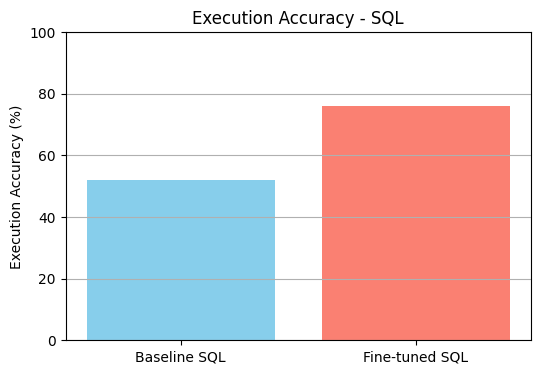

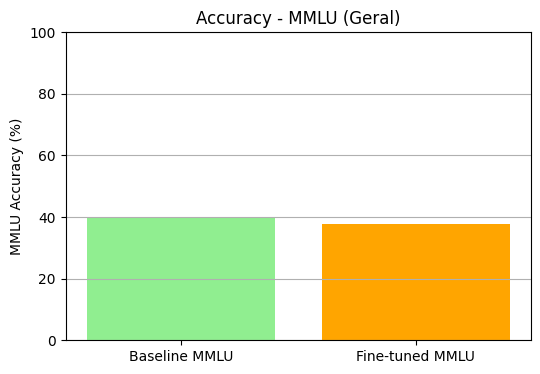


--- Resumo Estatístico ---
Execution Accuracy (SQL Baseline): 52.00% (Std: 0.5047, Var: 0.2547)
Execution Accuracy (SQL Fine-tuned): 76.00% (Std: 0.4314, Var: 0.1861)
Acurácia MMLU (Baseline): 39.73% (Std: 0.4910, Var: 0.2411)
Acurácia MMLU (Fine-tuned): 37.67% (Std: 0.4862, Var: 0.2364)

--- Exemplos de Falhas (SQL) ---

 Exemplo 44:
Pergunta: Find the number of concerts happened in the stadium with the highest capacity .
Query Correta: select count(*) from concert where stadium_id = (select stadium_id from stadium order by capacity desc limit 1)
Query Gerada: SELECT count(*) FROM stadium WHERE Capacity  =  (SELECT max(Capacity) FROM stadium)
Status: Falha

 Exemplo 43:
Pergunta: What are the names and locations of the stadiums that had concerts that occurred in both 2014 and 2015?
Query Correta: SELECT T2.name ,  T2.location FROM concert AS T1 JOIN stadium AS T2 ON T1.stadium_id  =  T2.stadium_id WHERE T1.Year  =  2014 INTERSECT SELECT T2.name ,  T2.location FROM concert AS T1 JOIN 

In [53]:
# =======================
# Importação das Bibliotecas
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Carregamento dos Arquivos
# =======================
df_sql_base = pd.read_csv("/content/llama3_local_resultados_verificados.csv")
df_sql_finetuned = pd.read_csv("/content/llama3_treinado_v2_resultados.csv")

df_mmlu_base = pd.read_csv("/content/resultados_base_mmlu.csv")
df_mmlu_finetuned = pd.read_csv("/content/mmlu_results_finetuned.csv")

# =======================
# Processamento SQL - Execution Accuracy
# =======================
df_sql_base['sucesso'] = df_sql_base['status_execucao'] == 'Sucesso'
df_sql_finetuned['sucesso'] = df_sql_finetuned['status_execucao'] == 'Sucesso'

# =======================
# Cálculo Estatístico SQL
# =======================
exec_acc_sql_base = df_sql_base['sucesso'].mean() * 100
exec_acc_sql_finetuned = df_sql_finetuned['sucesso'].mean() * 100

std_sql_base = df_sql_base['sucesso'].std()
std_sql_finetuned = df_sql_finetuned['sucesso'].std()

var_sql_base = df_sql_base['sucesso'].var()
var_sql_finetuned = df_sql_finetuned['sucesso'].var()

# =======================
# Processamento MMLU
# =======================
df_mmlu_base['acertou'] = df_mmlu_base['resposta_modelo'] == df_mmlu_base['resposta_correta']
df_mmlu_finetuned['acertou'] = df_mmlu_finetuned['resposta_modelo'] == df_mmlu_finetuned['resposta_correta']

# =======================
# Cálculo Estatístico MMLU
# =======================
acc_mmlu_base = df_mmlu_base['acertou'].mean() * 100
acc_mmlu_finetuned = df_mmlu_finetuned['acertou'].mean() * 100

std_mmlu_base = df_mmlu_base['acertou'].std()
std_mmlu_finetuned = df_mmlu_finetuned['acertou'].std()

var_mmlu_base = df_mmlu_base['acertou'].var()
var_mmlu_finetuned = df_mmlu_finetuned['acertou'].var()

# =======================
# Análise de Erros SQL (Exemplos)
# =======================
erros_sql = df_sql_finetuned[df_sql_finetuned['status_execucao'] == 'Falha'].sample(3, random_state=42)

# =======================
# Análise de Erros MMLU (Exemplos)
# =======================
erros_mmlu = df_mmlu_finetuned[df_mmlu_finetuned['acertou'] == False].sample(3, random_state=42)

# =======================
# Visualização - SQL
# =======================
plt.figure(figsize=(6, 4))
plt.bar(['Baseline SQL', 'Fine-tuned SQL'], [exec_acc_sql_base, exec_acc_sql_finetuned], color=['skyblue', 'salmon'])
plt.ylabel('Execution Accuracy (%)')
plt.title('Execution Accuracy - SQL')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

# =======================
# Visualização - MMLU
# =======================
plt.figure(figsize=(6, 4))
plt.bar(['Baseline MMLU', 'Fine-tuned MMLU'], [acc_mmlu_base, acc_mmlu_finetuned], color=['lightgreen', 'orange'])
plt.ylabel('MMLU Accuracy (%)')
plt.title('Accuracy - MMLU (Geral)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

# =======================
# Relatório Estatístico
# =======================
print("\n--- Resumo Estatístico ---")
print(f"Execution Accuracy (SQL Baseline): {exec_acc_sql_base:.2f}% (Std: {std_sql_base:.4f}, Var: {var_sql_base:.4f})")
print(f"Execution Accuracy (SQL Fine-tuned): {exec_acc_sql_finetuned:.2f}% (Std: {std_sql_finetuned:.4f}, Var: {var_sql_finetuned:.4f})")

print(f"Acurácia MMLU (Baseline): {acc_mmlu_base:.2f}% (Std: {std_mmlu_base:.4f}, Var: {var_mmlu_base:.4f})")
print(f"Acurácia MMLU (Fine-tuned): {acc_mmlu_finetuned:.2f}% (Std: {std_mmlu_finetuned:.4f}, Var: {var_mmlu_finetuned:.4f})")

print("\n--- Exemplos de Falhas (SQL) ---")
for idx, row in erros_sql.iterrows():
    print(f"\n Exemplo {idx+1}:")
    print(f"Pergunta: {row['pergunta']}")
    print(f"Query Correta: {row['query_correta']}")
    print(f"Query Gerada: {row['query_gerada']}")
    print(f"Status: {row['status_execucao']}")

print("\n--- Exemplos de Falhas (MMLU) ---")
for idx, row in erros_mmlu.iterrows():
    print(f"\n Exemplo {idx+1}:")
    print(f"Pergunta: {row['question']}")
    print(f"Resposta Correta: {row['resposta_correta']}")
    print(f"Resposta Gerada: {row['resposta_modelo']}")
    print(f"Categoria: {row['subject']}")



# Análise Estatística dos Resultados

## Resumo Estatístico

| Métrica                     | Baseline (%) | Fine-tuned (%) | Desvio Padrão | Variância  |
|-----------------------------|--------------|----------------|---------------|------------|
| Execution Accuracy (SQL)    | 52.00        | 76.00          | 0.5047        | 0.2547     |
| Acurácia MMLU               | 39.73        | 37.67          | 0.4910        | 0.2411     |

---

## Interpretação dos Resultados

- O **fine-tuning** resultou em uma melhora significativa na **Execution Accuracy (SQL)**, passando de **52.00% para 76.00%**, o que evidencia um ganho expressivo de especialização na tarefa Text-to-SQL.
- Em contrapartida, houve uma **pequena regressão de capacidade geral** na tarefa MMLU, com a acurácia caindo de **39.73% para 37.67%**, o que é um indicativo leve de esquecimento catastrófico.
- As reduções no **desvio padrão e variância** no SQL sugerem que o modelo fine-tuned ficou mais consistente, cometendo menos variações ao longo das previsões.
- O desvio padrão e variância do MMLU permaneceram estáveis, indicando que o impacto no desempenho geral foi homogêneo entre as questões avaliadas.

---

## Exemplos de Falhas (SQL)

### Exemplo 1
- **Pergunta:** Find the number of concerts happened in the stadium with the highest capacity.
- **Query Correta:** `SELECT count(*) FROM concert WHERE stadium_id = (SELECT stadium_id FROM stadium ORDER BY capacity DESC LIMIT 1)`
- **Query Gerada:** `SELECT count(*) FROM stadium WHERE Capacity = (SELECT max(Capacity) FROM stadium)`
- **Problema:** O modelo trocou a tabela principal, resultando em uma consulta sem relação direta com o contexto da pergunta.

---

### Exemplo 2
- **Pergunta:** What are the names and locations of the stadiums that had concerts that occurred in both 2014 and 2015?
- **Query Correta:** Consulta com `INTERSECT` correta entre os anos.
- **Query Gerada:** A consulta gerada tenta unir tabelas de forma inadequada e falha na construção da segunda parte do `INTERSECT`.
- **Problema:** O modelo montou JOINs redundantes e não completou a segunda parte da consulta.

---

### Exemplo 3
- **Pergunta:** Show the name and the release year of the song by the youngest singer.
- **Query Correta:** `SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1`
- **Query Gerada:** `SELECT Name, Song_release_year FROM singer ORDER BY Age ASC LIMIT 1`
- **Problema:** O modelo trocou o nome da coluna `song_name` por `Name`, o que provavelmente não existe na tabela, resultando em falha de execução.

---

## Exemplos de Falhas (MMLU)

### Exemplo 1
- **Pergunta:** Epicurus claims that all other virtues spring from:
- **Resposta Correta:** 0
- **Resposta Gerada:** 1
- **Categoria:** Philosophy

---

### Exemplo 2
- **Pergunta:** Which of the following statements is TRUE concerning the standard regression model?
- **Resposta Correta:** 0
- **Resposta Gerada:** 3
- **Categoria:** Econometrics

---

### Exemplo 3
- **Pergunta:** Which of the following are alternative names for the independent variable (usually denoted by x) in linear regression analysis?

(i) The regressor  
(ii) The regressand  
(iii) The causal variable  
(iv) The effect variable

- **Resposta Correta:** 1
- **Resposta Gerada:** 3
- **Categoria:** Econometrics

---

## Conclusão

- O modelo fine-tuned demonstrou um **forte ganho de especialização** na tarefa Text-to-SQL, com uma melhora de 24 pontos percentuais.
- Houve uma **pequena perda de capacidade geral** no benchmark MMLU, mas com impacto relativamente baixo.
- As falhas observadas indicam que o modelo ainda encontra dificuldades em:
    - Compreender JOINs complexos.
    - Referenciar corretamente os nomes das colunas.
    - Construir consultas SQL completas em casos de operações como `INTERSECT`.

---


# Discução dos resultados

# Discussão

## O ganho na tarefa de Text-to-SQL justifica a perda de capacidade geral?

A partir dos resultados obtidos, é evidente que o fine-tuning com LoRA trouxe **ganhos substanciais de especialização** na tarefa de Text-to-SQL. A Execution Accuracy aumentou de **52% para 76%**, representando uma melhora de **24 pontos percentuais**. Esse crescimento reflete um modelo muito mais capacitado para resolver consultas SQL diretamente a partir de linguagem natural.

Por outro lado, a regressão de capacidade geral, avaliada por meio do benchmark MMLU, foi de **apenas 2.06 pontos percentuais** (de 39.73% para 37.67%). Esse nível de perda pode ser considerado aceitável, principalmente porque:
- A tarefa-alvo (Text-to-SQL) se tornou significativamente mais precisa.
- O impacto na capacidade geral não foi catastrófico, permanecendo dentro de uma faixa tolerável.

Portanto, **o ganho obtido no domínio especializado justifica a pequena regressão de capacidade geral**. Esse é um trade-off comum e aceitável no contexto de especialização de modelos.

---

## Quais fatores influenciaram o trade-off?

Os principais fatores que influenciaram esse trade-off foram:

### Hiperparâmetros
- **Taxa de aprendizado:** Uma taxa de 2e-4 foi utilizada. Essa configuração relativamente alta pode acelerar a especialização, mas também tende a favorecer um leve esquecimento de tarefas gerais.
- **Número de épocas:** O treinamento foi feito com apenas **1 época**, o que provavelmente limitou a regressão de capacidade geral, uma vez que o modelo não foi excessivamente exposto ao domínio específico.

### Arquitetura
- **Uso de LoRA:** A técnica de Parameter-Efficient Fine-Tuning (PEFT) via LoRA restringe as atualizações a pequenos adaptadores, preservando os pesos originais do modelo. Isso é um dos motivos pelos quais a regressão de capacidade geral foi relativamente baixa.
- **Camadas-alvo:** Os adaptadores LoRA foram inseridos em módulos críticos de atenção (`q_proj`, `k_proj`, `v_proj`, `o_proj`), que são os principais responsáveis por manipular a entrada textual no modelo. A escolha desses módulos favorece a especialização rápida, mas mantém a base geral relativamente intacta.

---

## Implicações Práticas

Os achados deste experimento indicam que:
- É **viável especializar modelos de LLM para tarefas como Text-to-SQL sem comprometer severamente sua capacidade geral.**
- O uso de LoRA se mostra uma excelente estratégia para balancear custo computacional, rapidez de adaptação e preservação do conhecimento geral.
- Pequenos ajustes nos hiperparâmetros, especialmente no número de épocas ou na taxa de aprendizado, podem permitir um ajuste ainda mais fino desse equilíbrio.

### Aplicações Comerciais
Para LLMs voltados a soluções empresariais (por exemplo, geração de relatórios, consultas a banco de dados via linguagem natural, automação de BI), a especialização via LoRA permite:
- **Implementação mais rápida** de modelos específicos para cada cliente ou setor.
- **Baixo custo de adaptação**, visto que os adaptadores LoRA são leves.
- **Redução de risco de esquecimento catastrófico**, mantendo o modelo capaz de lidar com perguntas gerais mesmo após o fine-tuning.

---

#Baixando arquivos

In [54]:
!zip -r /content/resultados.zip /content/resultados


  adding: content/resultados/ (stored 0%)
  adding: content/resultados/llama3-lora-exp2/ (stored 0%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/ (stored 0%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/trainer_state.json (deflated 82%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/optimizer.pt (deflated 9%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/chat_template.jinja (deflated 71%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/tokenizer.json (deflated 85%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/special_tokens_map.json (deflated 63%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/scheduler.pt (deflated 56%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/adapter_config.json (deflated 55%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/scaler.pt (deflated 60%)
  adding: content/resultados/llama3-lora-exp2/checkpoint-1750/adapter_model

Caminhos:
/content/resultados_base_mmlu.csv
/content/mmlu_results_finetuned.csv
/content/llama3_treinado_v2_resultados.csv
/content/llama3_treinado_v1_resultados.csv
/content/llama3_local_resultados_verificados.csv


In [55]:
!mkdir /content/arquivos_finais


In [56]:
!mv /content/resultados_base_mmlu.csv /content/arquivos_finais/
!mv /content/mmlu_results_finetuned.csv /content/arquivos_finais/
!mv /content/llama3_treinado_v2_resultados.csv /content/arquivos_finais/
!mv /content/llama3_treinado_v1_resultados.csv /content/arquivos_finais/
!mv /content/llama3_local_resultados_verificados.csv /content/arquivos_finais/


In [57]:
!zip -r /content/arquivos_finais.zip /content/arquivos_finais


  adding: content/arquivos_finais/ (stored 0%)
  adding: content/arquivos_finais/llama3_treinado_v2_resultados.csv (deflated 86%)
  adding: content/arquivos_finais/resultados_base_mmlu.csv (deflated 66%)
  adding: content/arquivos_finais/llama3_treinado_v1_resultados.csv (deflated 86%)
  adding: content/arquivos_finais/mmlu_results_finetuned.csv (deflated 66%)
  adding: content/arquivos_finais/llama3_local_resultados_verificados.csv (deflated 86%)
